In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import time

from numba import cuda
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Load the TensorBoard notebook extension
%load_ext tensorboard
%matplotlib inline

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [ ]:
!nvidia-smi

Thu Mar  9 10:33:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
tf.random.set_seed(43)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
tf.config.set_soft_device_placement(True)

#### Data load and preprocessing

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, 
                              as_supervised=True,
                              data_dir="d:\Data\Study\\")

Dataset cycle_gan downloaded and prepared to d:\Data\Study\/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [ ]:
type(dataset['trainA']), type(dataset['trainA'].take(100))

(tensorflow.python.data.ops.dataset_ops.PrefetchDataset,
 tensorflow.python.data.ops.dataset_ops.TakeDataset)

In [ ]:
train_horses

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
len(train_horses), len(train_zebras), len(test_horses), len(test_zebras)

(1067, 1334, 120, 140)

In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [ ]:
def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [ ]:
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [ ]:
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [ ]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

In [ ]:
sample_horse

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[-0.7411765 , -0.52156866, -0.4980392 ],
         [-0.73333335, -0.5137255 , -0.49019605],
         [-0.70980394, -0.5058824 , -0.4980392 ],
         ...,
         [-0.81960785, -0.4588235 , -0.47450978],
         [-0.8117647 , -0.45098037, -0.46666664],
         [-0.7882353 , -0.42745095, -0.44313723]],

        [[-0.69411767, -0.47450978, -0.44313723],
         [-0.6862745 , -0.46666664, -0.4352941 ],
         [-0.6627451 , -0.46666664, -0.4352941 ],
         ...,
         [-0.7882353 , -0.44313723, -0.45098037],
         [-0.78039217, -0.41960782, -0.4352941 ],
         [-0.7647059 , -0.40392154, -0.41960782]],

        [[-0.6784314 , -0.45098037, -0.41960782],
         [-0.654902  , -0.4352941 , -0.40392154],
         [-0.654902  , -0.4352941 , -0.41176468],
         ...,
         [-0.77254903, -0.42745095, -0.4352941 ],
         [-0.7647059 , -0.40392154, -0.41960782],
         [-0.7411765 , -0.38039213, -0.3960784

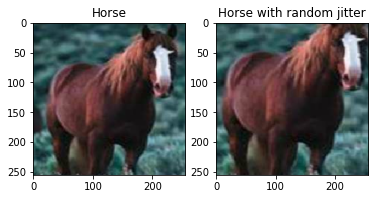

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse.numpy()[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse.numpy()[0]) * 0.5 + 0.5)

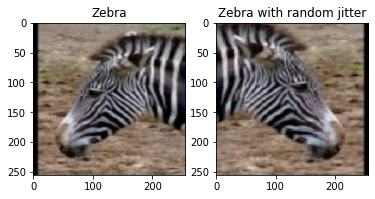

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

#### Importing Pix2Pix models

We will take the generator and discriminator from the Pix2Pix model, the generation will be carried out using Unet.

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

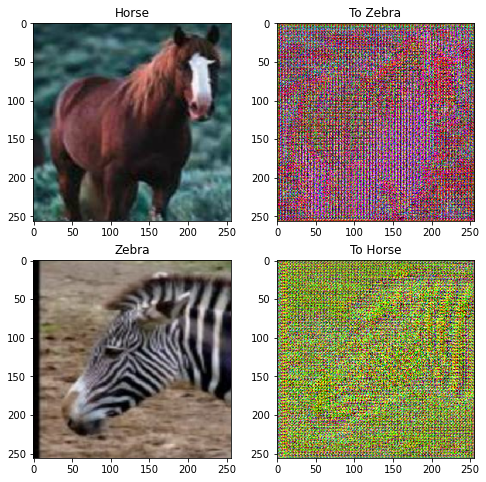

In [ ]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

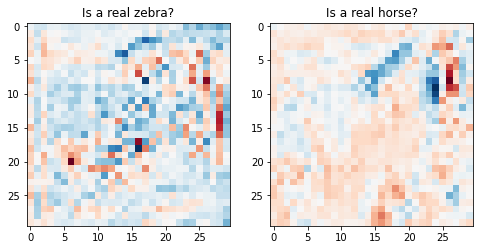

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

#### Loss functions

Generator Loss :

It is a sigmoid cross-entropy loss of the generated images and an array of ones (‘1s’) so that it allows generated images to become structurally similar to the target images.

Discriminator Loss :

Discriminator loss function takes 2 inputs i.e., real images and generated images.

-real_loss is a sigmoid cross-entropy loss of real images and an array of ones (because these are real images) and generated_loss is a sigmoid cross-entropy loss of generated images and an array of zeros (because these are fake images).

-And total_loss is the sum of real_loss and generated_loss.

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA=10

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5


def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)


def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1


def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

#### Initialization of optimizers for all generators and all discriminators.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Checkpoints

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

#### Training

In [ ]:
EPOCHS = 30

In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
    
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
       
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, 
                                                  discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, 
                                                  discriminator_y.trainable_variables))

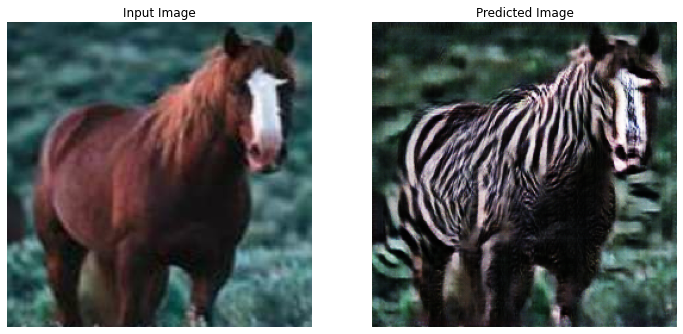

Saving checkpoint for epoch 30 at ./checkpoints/train/ckpt-6
Time taken for epoch 30 is 452.1210985183716 sec

CPU times: user 2h 5min 31s, sys: 1h 22min 44s, total: 3h 28min 15s
Wall time: 3h 43min 23s


In [ ]:
%%time

for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_horse)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))
        generator_g.save(f'generator_g_{epoch}_epochs.h5')

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

#### Generate using test dataset

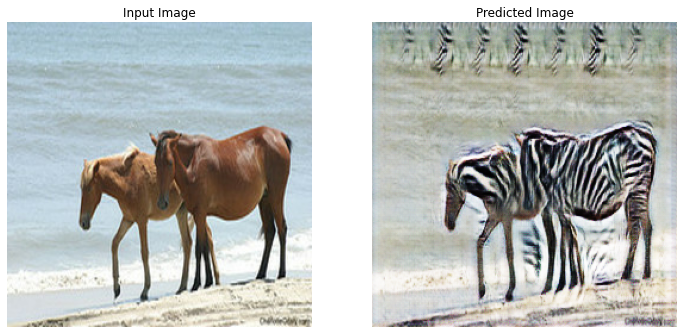

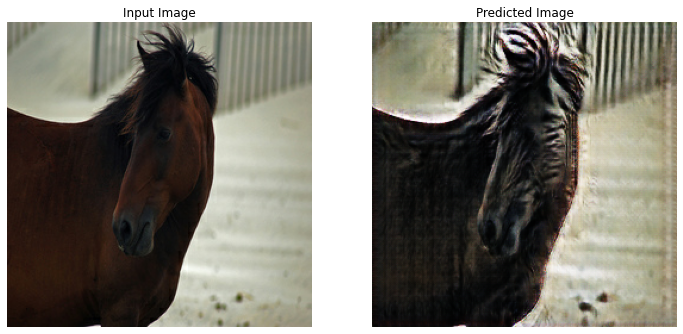

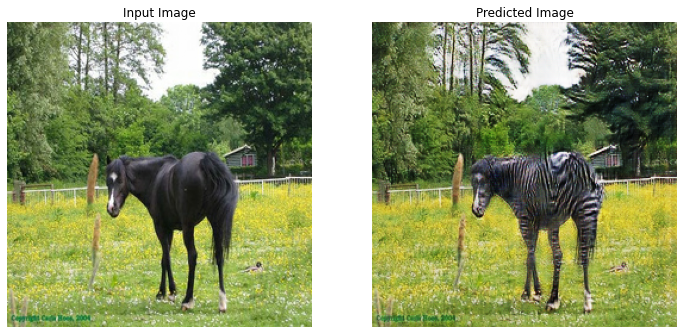

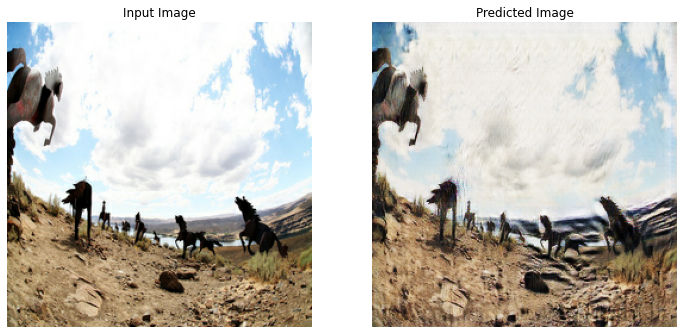

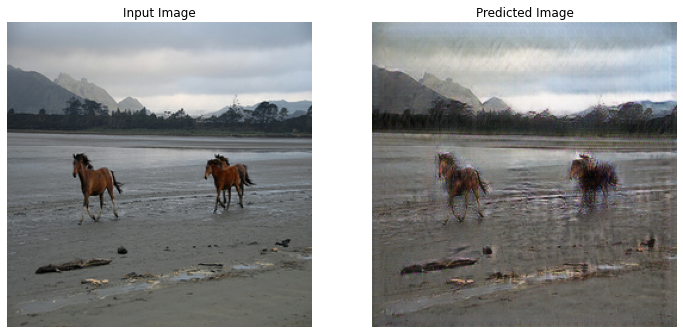

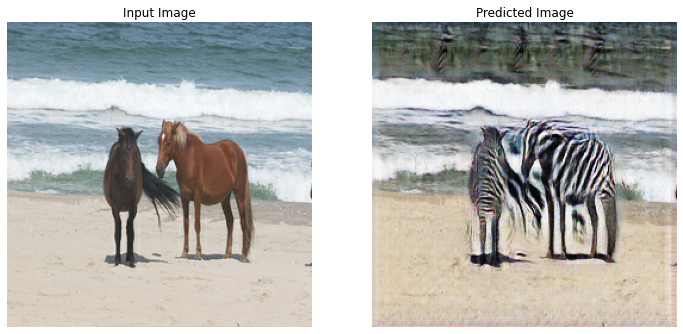

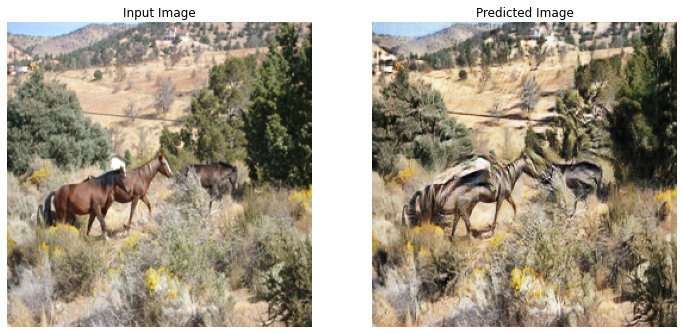

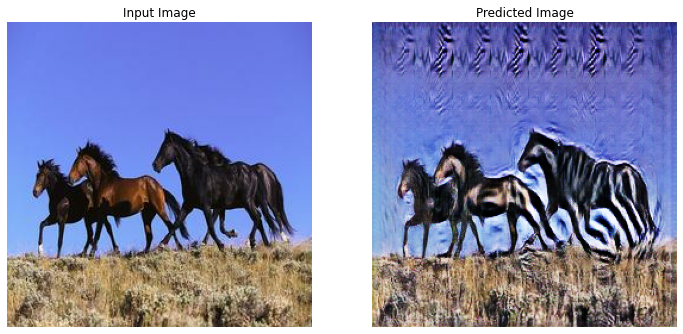

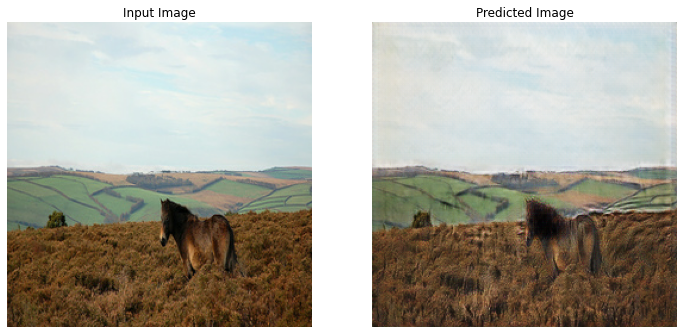

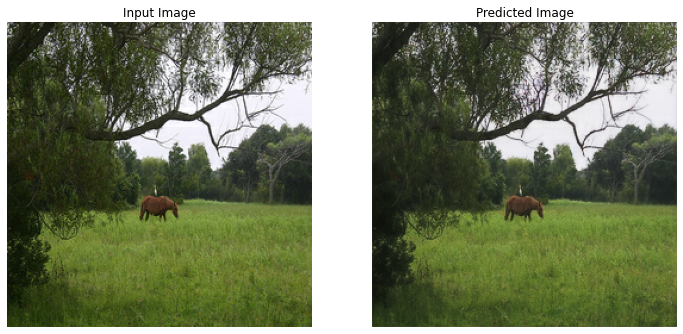

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(10):
    generate_images(generator_g, inp)

In [ ]:
generator_g.save('generator_g_30_epochs.h5')

In [ ]:
generator_g.save_weights('generator_g_weights')

In [ ]:
generator_f.save('generator_g_30_epochs.h5')

Чем меньше LAMBDA тем лучше качество обучения модели (брал lambda=100 и lambda=10)

In [ ]:
cuda.close()